In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import lightgbm as lgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("Walmart DataSet.csv")
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df = df[df['Store'] == 1]
df = df.rename(columns={"Weekly_Sales": "Sales"})

df.set_index('Date', inplace=True)
df = df.resample('W').sum()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 143 entries, 2010-02-07 to 2012-10-28
Freq: W-SUN
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         143 non-null    int64  
 1   Sales         143 non-null    float64
 2   Holiday_Flag  143 non-null    int64  
 3   Temperature   143 non-null    float64
 4   Fuel_Price    143 non-null    float64
 5   CPI           143 non-null    float64
 6   Unemployment  143 non-null    float64
dtypes: float64(5), int64(2)
memory usage: 8.9 KB


In [4]:
df.describe()

,Store,Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,143.0,1.430000e+02,143.000000,143.000000,143.000000,143.000000,143.000000
mean,1.0,1.555264e+06,0.069930,68.306783,3.219699,215.996892,7.610420
std,0.0,1.559808e+05,0.255926,14.250486,0.427313,4.350890,0.383749
min,1.0,1.316899e+06,0.000000,35.400000,2.514000,210.337426,6.573000
25%,1.0,1.458105e+06,0.000000,58.265000,2.764500,211.549277,7.348000
50%,1.0,1.534850e+06,0.000000,69.640000,3.290000,215.459905,7.787000
75%,1.0,1.614892e+06,0.000000,80.485000,3.594000,220.531330,7.838000
max,1.0,2.387950e+06,1.000000,91.650000,3.907000,223.444251,8.106000


In [5]:
df.isnull().sum()

,0
Store,0
Sales,0
Holiday_Flag,0
Temperature,0
Fuel_Price,0
CPI,0
Unemployment,0


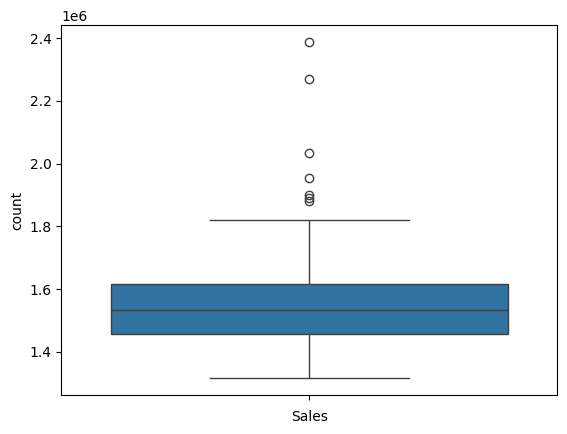

In [6]:
sns.boxplot(data = df['Sales'])
plt.xlabel('Sales')
plt.ylabel('count')
plt.show()

In [7]:
Q1 = df['Sales'].quantile(0.25)
Q3 = df['Sales'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['Sales'] >= lower_bound) & (df['Sales'] <= upper_bound)]

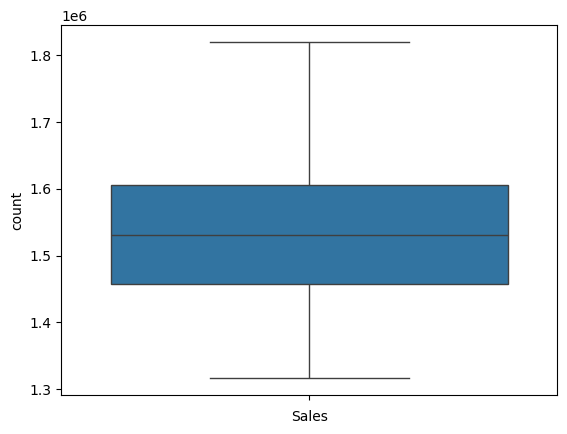

In [17]:
sns.boxplot(data = df['Sales'])
plt.xlabel('Sales')
plt.ylabel('count')
plt.show()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 136 entries, 2010-02-07 to 2012-10-28
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         136 non-null    int64  
 1   Sales         136 non-null    float64
 2   Holiday_Flag  136 non-null    int64  
 3   Temperature   136 non-null    float64
 4   Fuel_Price    136 non-null    float64
 5   CPI           136 non-null    float64
 6   Unemployment  136 non-null    float64
dtypes: float64(5), int64(2)
memory usage: 8.5 KB


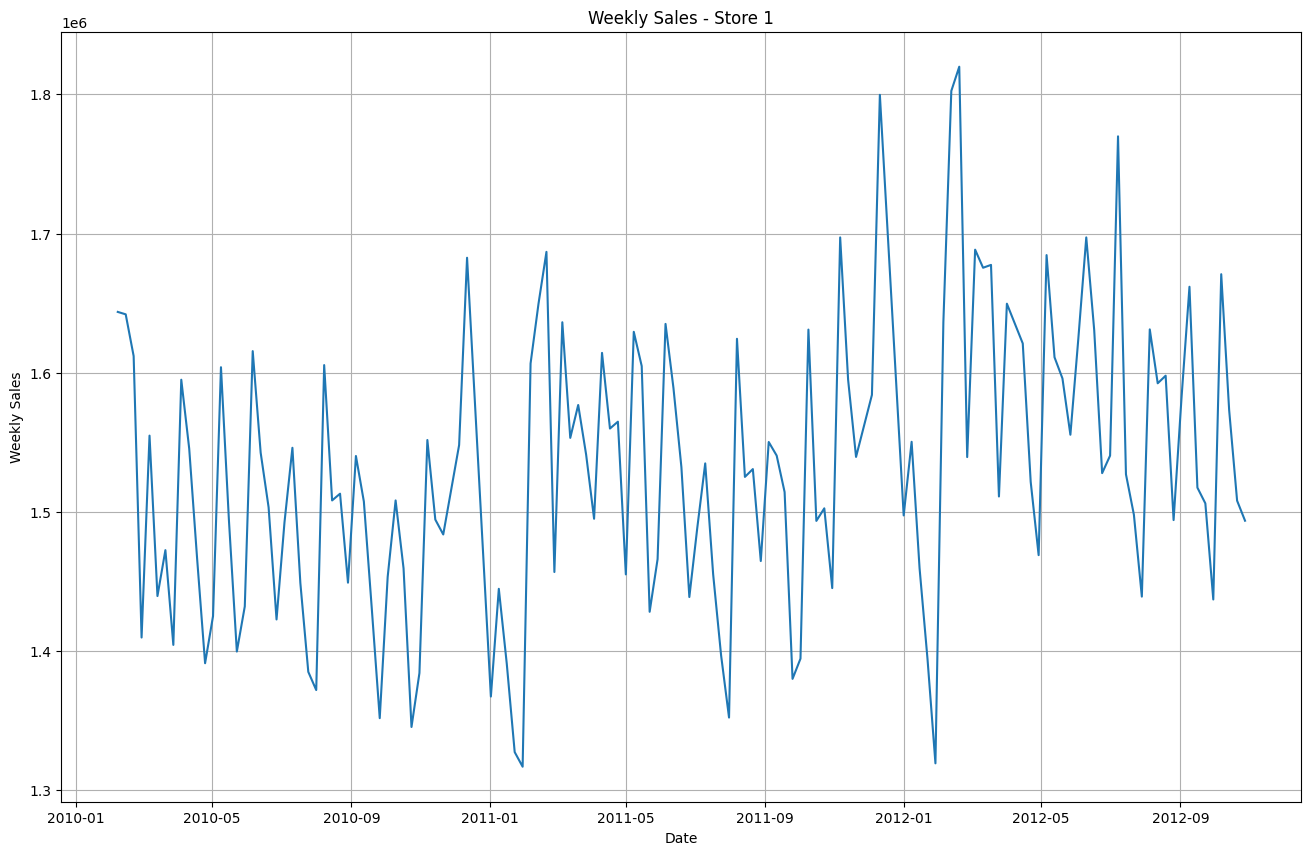

In [9]:
plt.figure(figsize=(16, 10))
plt.plot(df['Sales'])
plt.title("Weekly Sales - Store 1")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.grid(True)
plt.show()

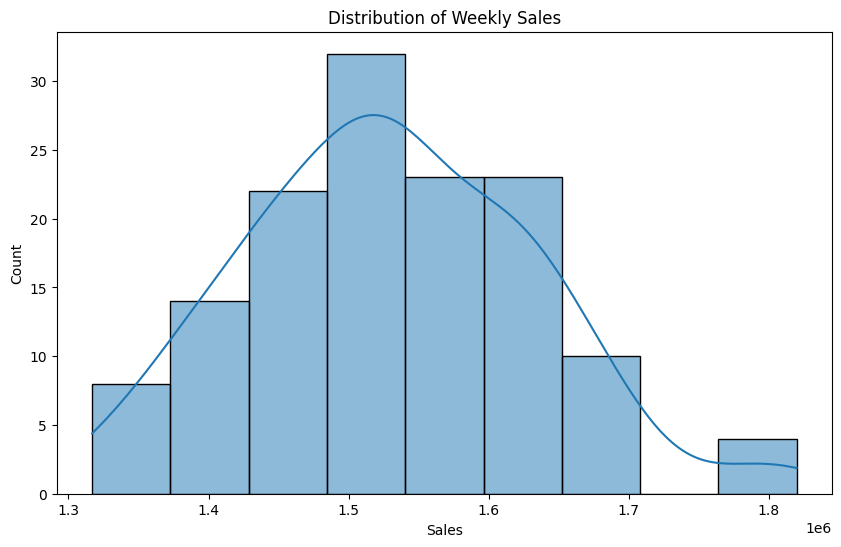

In [10]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Sales'], kde=True)
plt.title("Distribution of Weekly Sales")
plt.show()

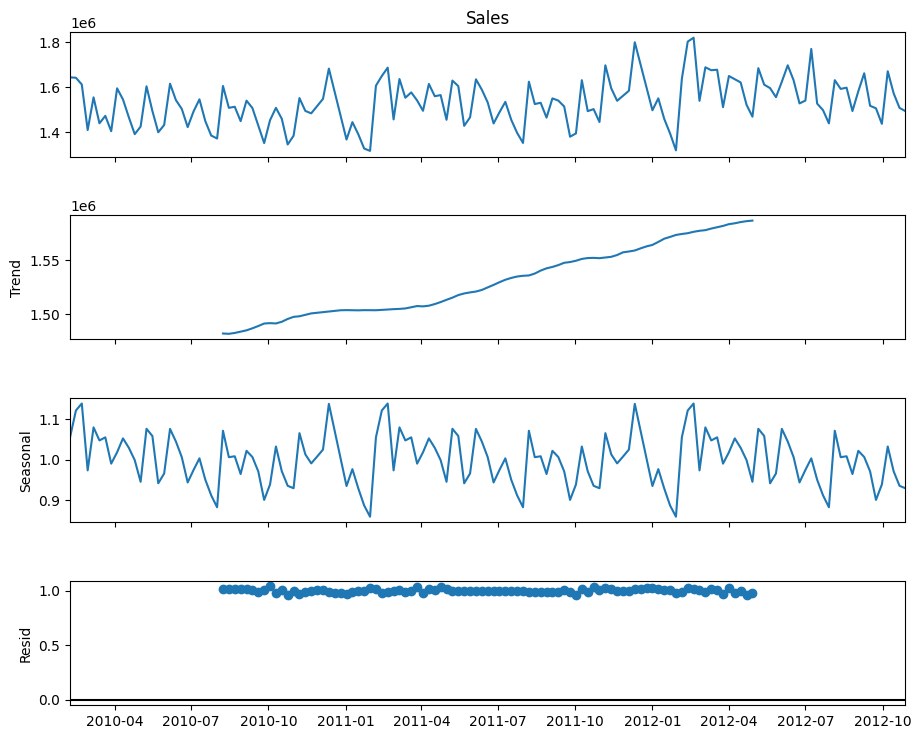

In [11]:
df = df.asfreq('W-SUN')
df['Sales'] = df['Sales'].interpolate(method='linear')
seasonal = seasonal_decompose(df['Sales'], model='multiplicative')
fig = seasonal.plot()
fig.set_size_inches(10, 8)
plt.show()

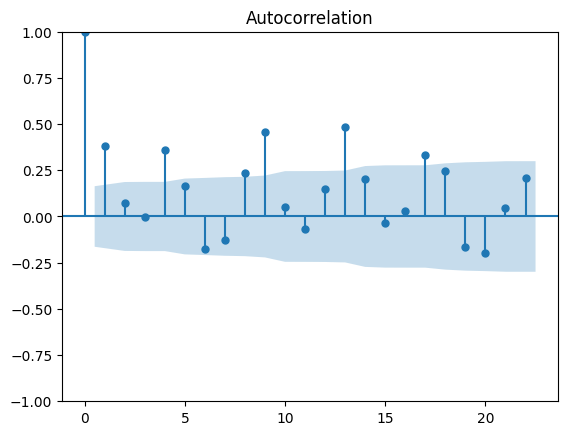

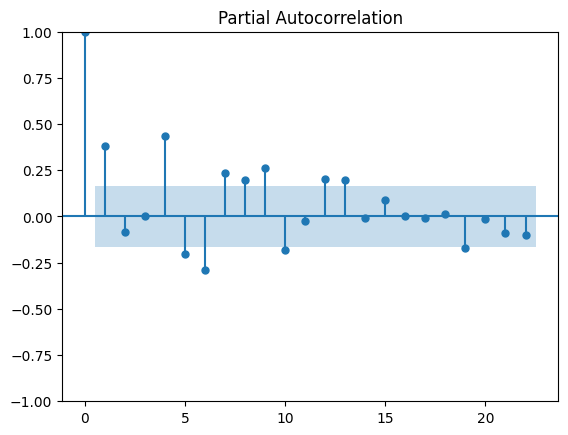

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df['Sales'])
plt.show()
plot_pacf(df['Sales'])
plt.show()

In [13]:
def interpret_dftest(dftest):
    return pd.Series(dftest[0:2], index=['Test Statistic', 'p-value'])

interpret_dftest(adfuller(df['Sales']))
interpret_dftest(adfuller(df['Sales'].diff().dropna()))

,0
Test Statistic,-6.985552e+00
p-value,7.986155e-10


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


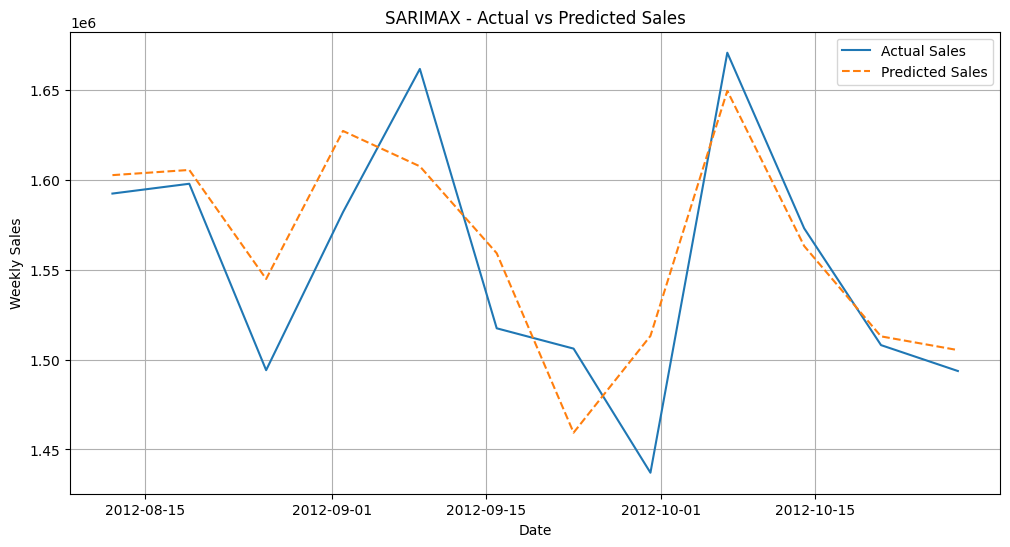

RMSE: 38894.70653728537
MAE: 31693.146754067955


In [14]:
log_sales = np.log(df['Sales'])
diff_log_sales = log_sales.diff().dropna()
train = diff_log_sales[:-12]
test = diff_log_sales[-12:]

model = SARIMAX(train, order=(1,0,1), seasonal_order=(1,0,1,52), enforce_stationarity=False, enforce_invertibility=False)
results = model.fit(disp=False)

forecast = results.get_forecast(steps=12)
predicted_diff_log = forecast.predicted_mean
last_log_value = log_sales[train.index[-1]]
predicted_log = predicted_diff_log.cumsum() + last_log_value
predicted_sales = np.exp(predicted_log)

actual_sales = df['Sales'].loc[test.index]
rmse = np.sqrt(mean_squared_error(actual_sales, predicted_sales))
mae = mean_absolute_error(actual_sales, predicted_sales)

plt.figure(figsize=(12, 6))
plt.plot(actual_sales.index, actual_sales, label='Actual Sales')
plt.plot(predicted_sales.index, predicted_sales, label='Predicted Sales', linestyle='--')
plt.title("SARIMAX - Actual vs Predicted Sales")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend()
plt.grid(True)
plt.show()

print("RMSE:", rmse)
print("MAE:", mae)

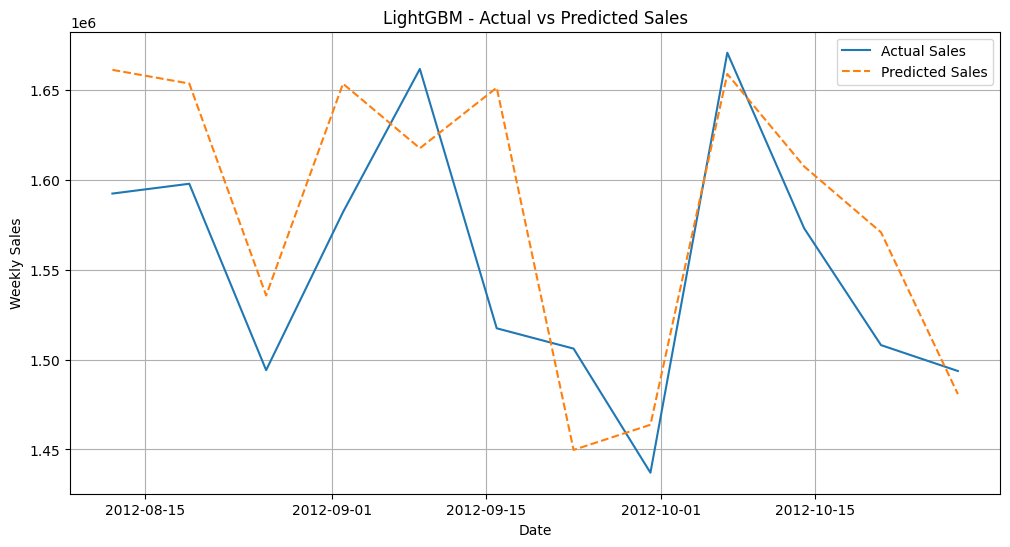

RMSE: 60479.324119437115
MAE: 51725.70472924353


In [15]:
df_lgbm = df.copy()
df_lgbm['lag_1'] = df_lgbm['Sales'].shift(1)
df_lgbm['lag_2'] = df_lgbm['Sales'].shift(2)
df_lgbm['lag_3'] = df_lgbm['Sales'].shift(3)
df_lgbm['lag_4'] = df_lgbm['Sales'].shift(4)
df_lgbm['lag_52'] = df_lgbm['Sales'].shift(52)

df_lgbm['day'] = df_lgbm.index.day
df_lgbm['month'] = df_lgbm.index.month
df_lgbm['year'] = df_lgbm.index.year
df_lgbm['weekofyear'] = df_lgbm.index.isocalendar().week.astype(int)

df_lgbm.dropna(inplace=True)
X = df_lgbm.drop(columns=['Sales'])
y = df_lgbm['Sales']
X_train, X_test = X[:-12], X[-12:]
y_train, y_test = y[:-12], y[-12:]

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1
}

lgb_model = lgb.train(params, train_data, valid_sets=[train_data, test_data],
                      num_boost_round=100)

y_pred = lgb_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, label='Actual Sales')
plt.plot(y_test.index, y_pred, label='Predicted Sales', linestyle='--')
plt.title("LightGBM - Actual vs Predicted Sales")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend()
plt.grid(True)
plt.show()

print("RMSE:", rmse)
print("MAE:", mae)

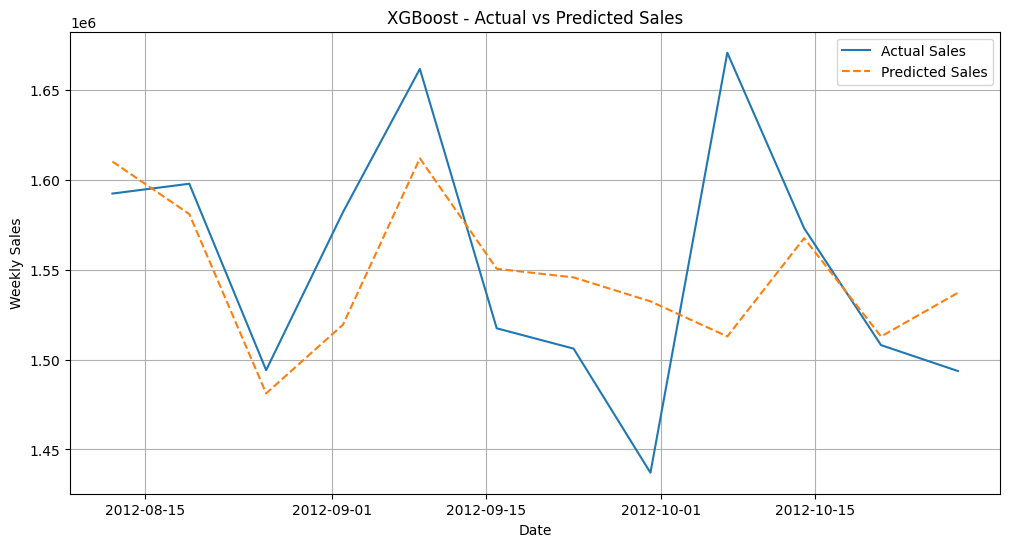

RMSE: 61782.608692265465
MAE: 44986.13708333331


In [16]:
X = df.drop(columns=['Sales'])
y = df['Sales']

X_train, X_test = X[:-12], X[-12:]
y_train, y_test = y[:-12], y[-12:]

model = XGBRegressor(objective='reg:squarederror', n_estimators=100)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, label='Actual Sales')
plt.plot(y_test.index, y_pred, label='Predicted Sales', linestyle='--')
plt.title("XGBoost - Actual vs Predicted Sales")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend()
plt.grid(True)
plt.show()

print("RMSE:", rmse)
print("MAE:", mae)